In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from keras.callbacks import EarlyStopping

import cv2
import imghdr

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3844\405083112.py:13: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# 1. Prepare Data

In [2]:
data_dir = 'dataset_ori'
img_exts = ['jpeg', 'jpg', 'bmp', 'png']
os.listdir(data_dir)

['not_porn', 'porn']

## 1.1 Setup

In [3]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in img_exts:
#                 print(f'Image not in extension list {image_path}')
#                 os.remove(image_path)
#         except Exception as e:
#             print(f'Issue with image {image_path}')

## 1.2 Load Data

In [4]:
data = tf.keras.utils.image_dataset_from_directory('dataset_ori')

Found 6400 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

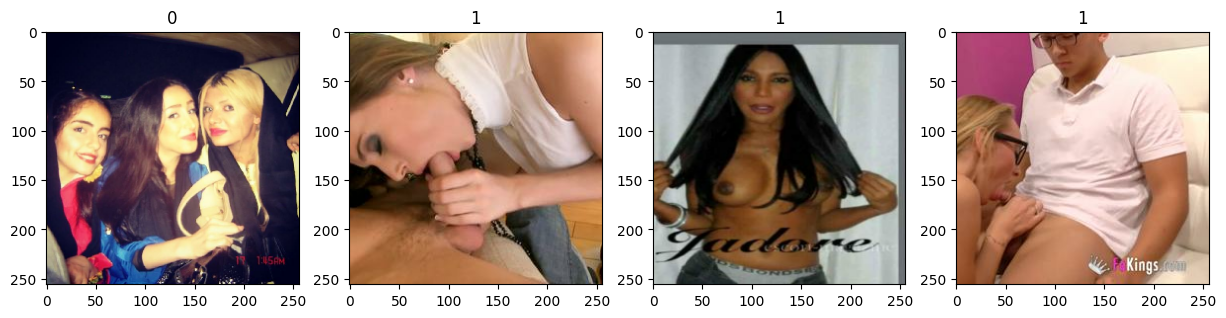

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data

## 2.1 Scale Data

In [7]:
data = data.map(lambda x, y: (x / 255, y))

In [8]:
scaled_iterator = data.as_numpy_iterator()

In [9]:
batch = scaled_iterator.next()

## 2.2 Split Data

In [10]:
len(data)

200

In [11]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Build Model

## 3.1 Build CNN Model

In [13]:
model = Sequential()

In [14]:
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Train Model

In [17]:
logdir = 'logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[early_stopping]
)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 57s 391ms/step - accuracy: 0.6864 - loss: 0.6736 - val_accuracy: 0.8281 - val_loss: 0.4018
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 391ms/step - accuracy: 0.8512 - loss: 0.3644 - val_accuracy: 0.8602 - val_loss: 0.3535
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 373ms/step - accuracy: 0.8838 - loss: 0.3071 - val_accuracy: 0.8719 - val_loss: 0.3154
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - accuracy: 0.8873 - loss: 0.2668 - val_accuracy: 0.8750 - val_loss: 0.2921
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.9102 - loss: 0.2233 - val_accuracy: 0.8648 - val_loss: 0.3198
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 54s 388ms/step - accuracy: 0.9238 - loss: 0.1934 - val_accuracy: 0.8867 - val_loss: 0.2851
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 389ms/step - accuracy: 0.9369 - loss: 0.1579 - val_accuracy: 0.8844 - val_loss: 0.3230
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 53s 377ms/step - accuracy: 0.9378 - loss: 0

## 3.3 Plot Performance

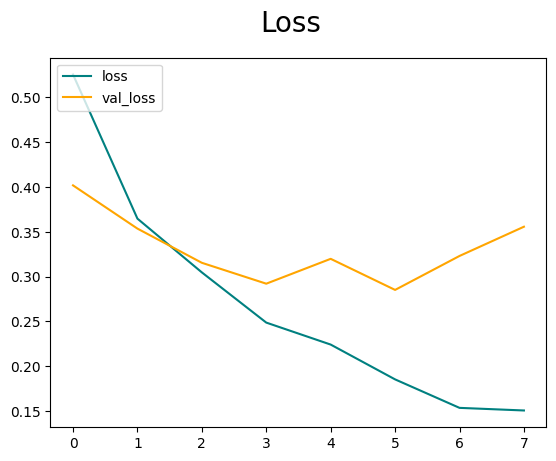

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

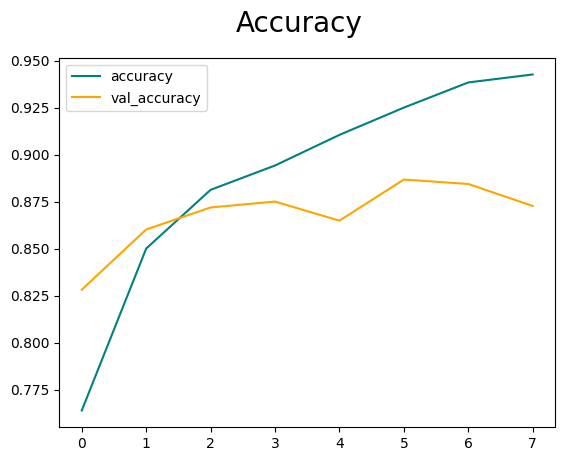

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Model Evaluation

## 4.1 Precision, Recall, Accuracy, Confusion Matrix

In [22]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [24]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.9208860993385315
Recall: 0.8871951103210449
Accuracy: 0.903124988079071


## 4.2 Test

In [39]:
img = cv2.imread('fresh_images/not-2.jpg')
resize = tf.image.resize(img, (256,256))

yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [40]:
yhat

array([[0.12959808]], dtype=float32)

In [41]:
if yhat > 0.5:
    print(f'Predicted image is Porn')
else:
    print(f'Predicted image is Not Porn')

Predicted image is Not Porn
